# Using the dots image

In [1]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick
from skimage import measure
import skimage

# Detection of data points
### The DOTS image is used. I create a BINARY mask of them based on an appropriate threshold, enlarge them and then label them.

In [2]:
data = pyfits.getdata('calibration_points.fits')
dark = pyfits.getdata('dark.fits')
#data = data-dark
data = data/data.mean()
hdu =pyfits.PrimaryHDU(data)
#hdu.writeto('calibration_points_norm.fits')


In [3]:
mask = np.zeros((2048,2048))
for i in range(2048):
    for j in range(2048):
        if data[i][j] > 2:
            mask[i][j] = 1
        else:
            mask[i][j] = 0


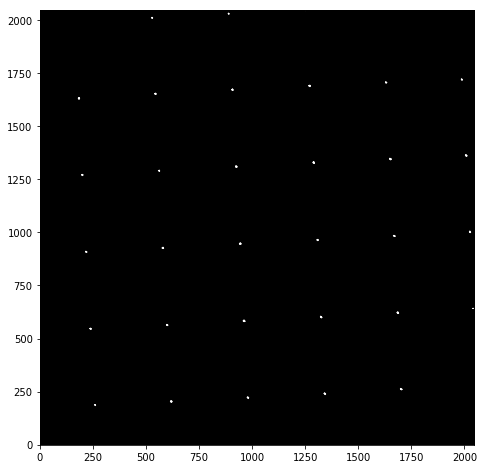

In [4]:
from scipy.ndimage.filters import gaussian_filter as gf
mask_smooth = gf(mask,sigma=1,mode='nearest')
fig = plt.figure(figsize=(15,8))
plt.imshow(mask_smooth,cmap='gray',origin='lower')
plt.savefig('dots.png',dpi=300)

# Extending the mask

In [54]:
mask_2 = np.zeros((2048,2048))
for i in range(2048):
         for j in range(2048):
             if mask_smooth[i][j] > 0.1:

                   mask_2[i][j] = 1
             else:
                   mask_2[i][j] = 0

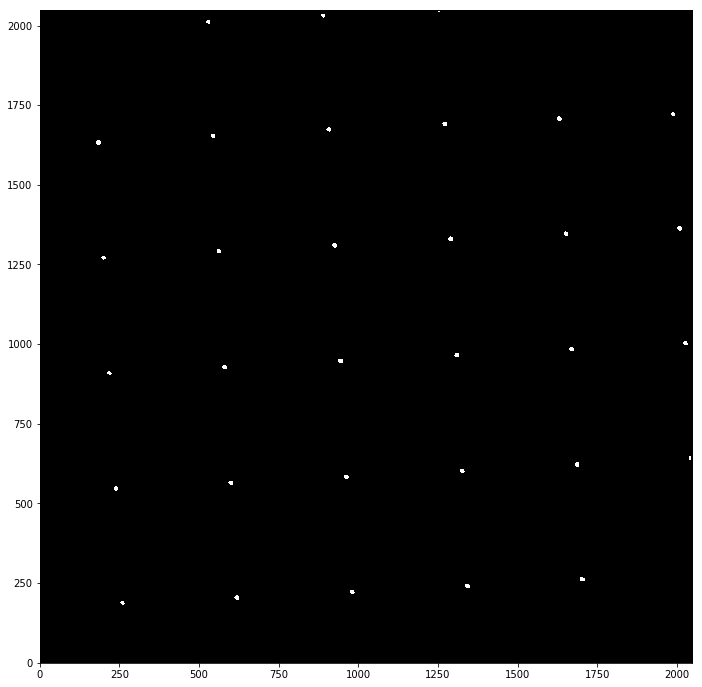

In [55]:
fig = plt.figure(figsize=(18,12))
plt.imshow(mask_2,cmap='gray', origin='lower')


# Using the extended mask to label data points and measure their properties


In [68]:
from skimage import measure
from skimage.measure import label
from skimage.measure import regionprops


labels, numb = measure.label(mask_2,background=0, return_num=True)
props = skimage.measure.regionprops(labels)
centers = np.array([prop.centroid for prop in props])

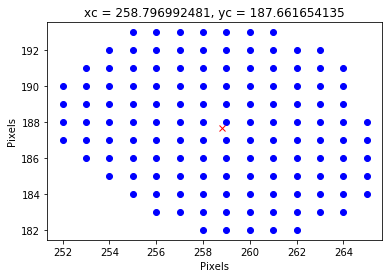

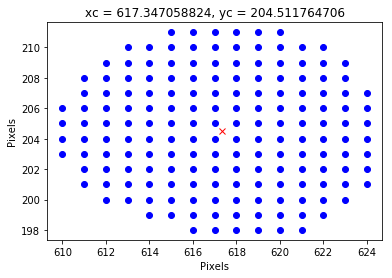

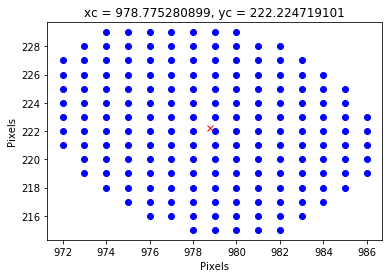

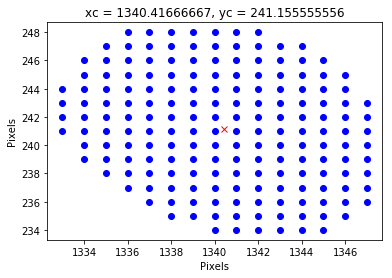

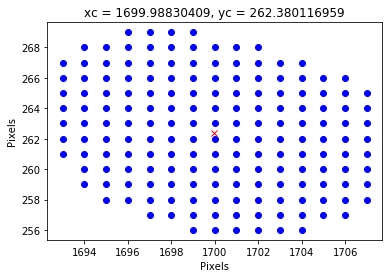

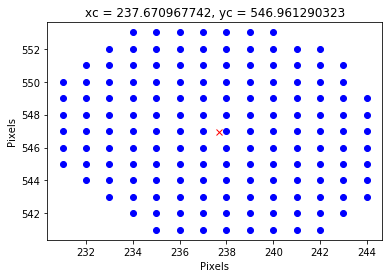

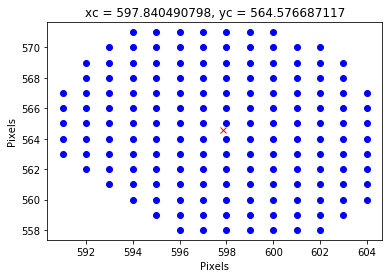

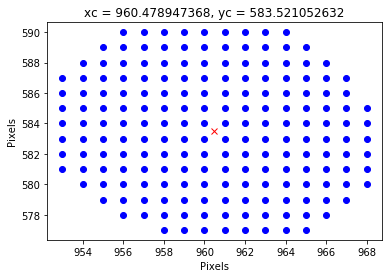

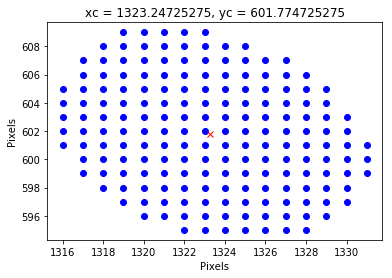

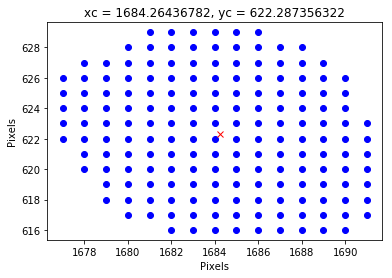

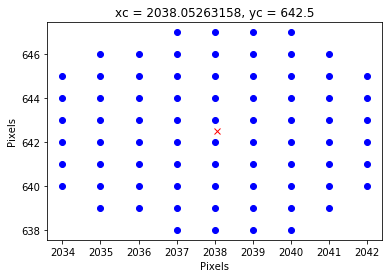

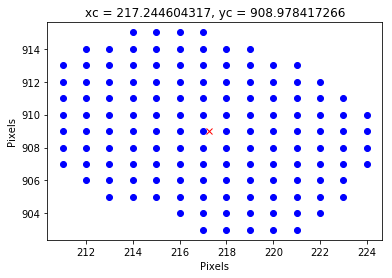

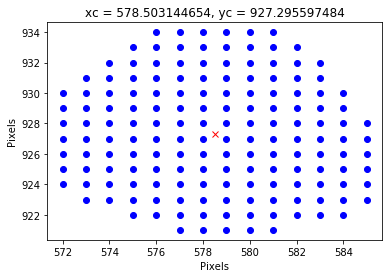

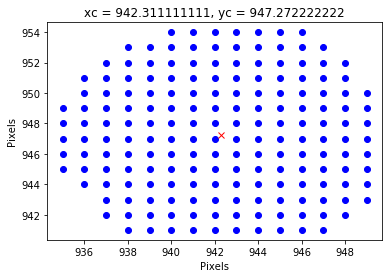

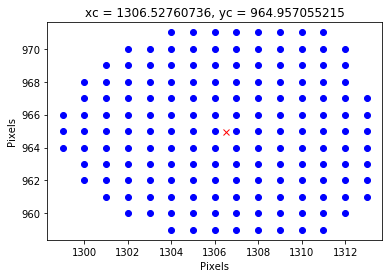

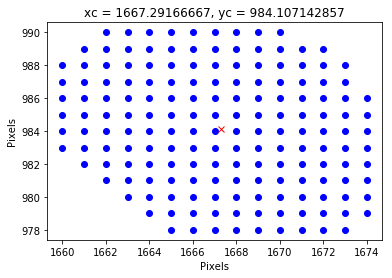

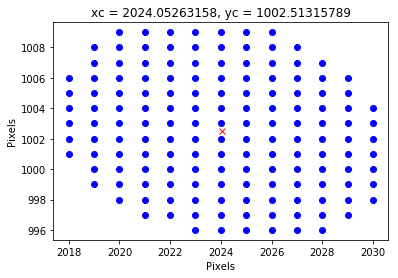

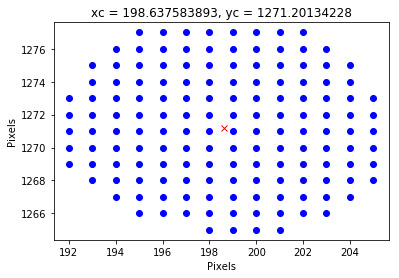

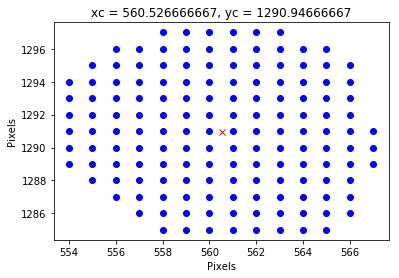

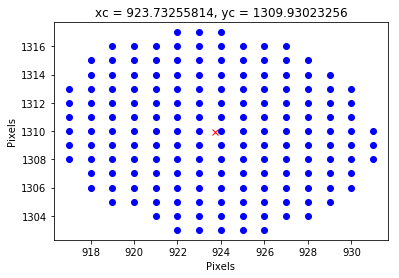

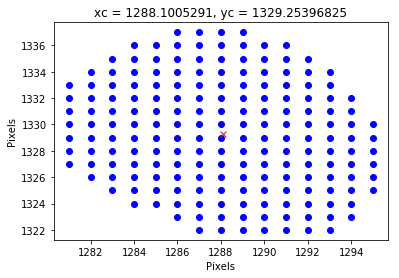

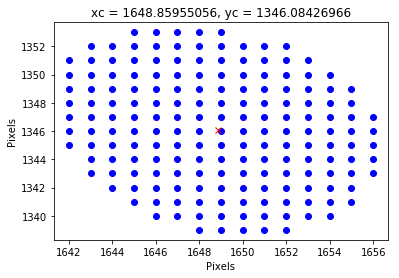

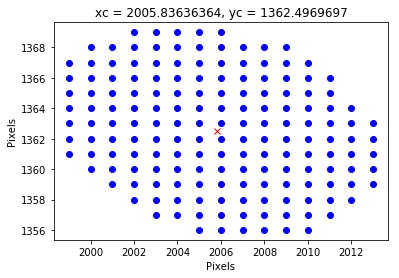

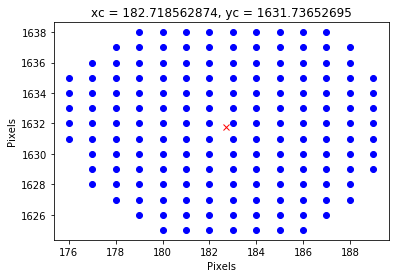

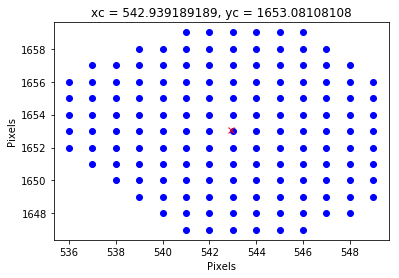

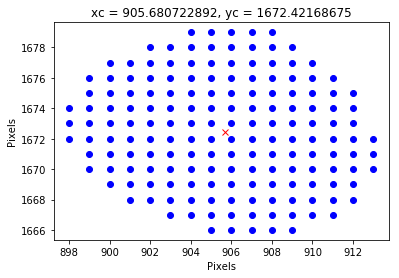

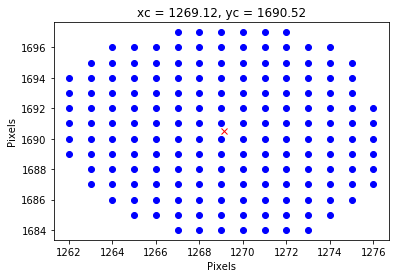

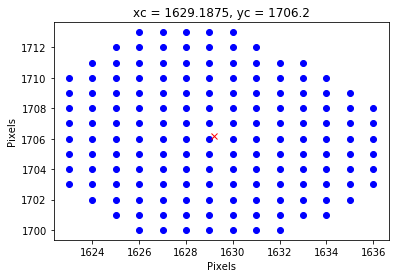

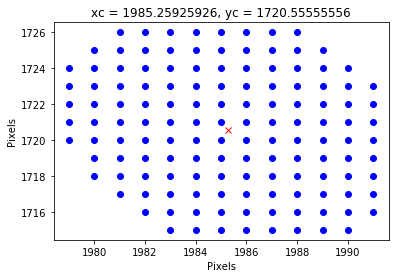

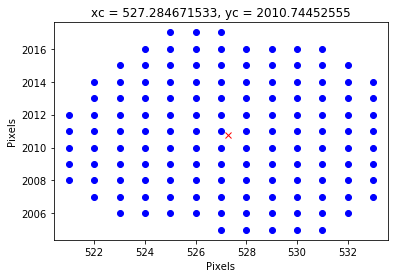

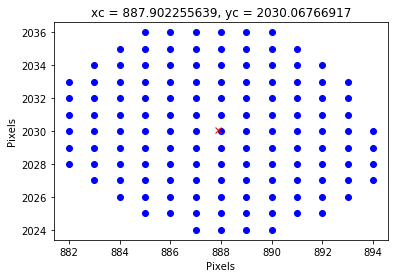

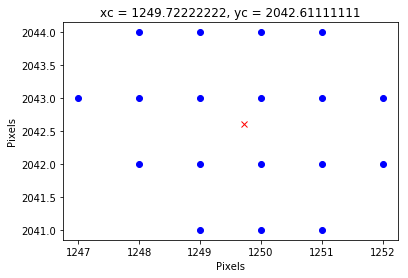

In [69]:
for i in np.arange(numb):
    y, x = props[i].coords[:,0], props[i].coords[:,1]
    yc, xc = props[i].centroid
    plt.plot(x,y,'bo')
    plt.plot(xc,yc,'rx')
    #plt.title('Feature# '+str(label),fontsize=22)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    plt.title('xc = '+str(xc)+', yc = '+str(yc))
    plt.show()
plt.show()

In [9]:
'''
F = open('Centers_python_dots','w')
for i in range(32):
    F.write(str(centers[i][1]) + ' '+ str(centers[i][0])+'\n')
F.close()
'''

In [68]:
for i in range(32):
 print centers[i][1],  centers[i][0]


258.796992481 187.661654135
617.347058824 204.511764706
978.775280899 222.224719101
1340.41666667 241.155555556
1699.98830409 262.380116959
237.670967742 546.961290323
597.840490798 564.576687117
960.478947368 583.521052632
1323.24725275 601.774725275
1684.26436782 622.287356322
2038.05263158 642.5
217.244604317 908.978417266
578.503144654 927.295597484
942.311111111 947.272222222
1306.52760736 964.957055215
1667.29166667 984.107142857
2024.05263158 1002.51315789
198.637583893 1271.20134228
560.526666667 1290.94666667
923.73255814 1309.93023256
1288.1005291 1329.25396825
1648.85955056 1346.08426966
2005.83636364 1362.4969697
182.718562874 1631.73652695
542.939189189 1653.08108108
905.680722892 1672.42168675
1269.12 1690.52
1629.1875 1706.2
1985.25925926 1720.55555556
527.284671533 2010.74452555
887.902255639 2030.06766917
1249.72222222 2042.61111111


# fitting circles to the features to derive their centers

258.796992481 187.661654135
258.758841039 187.623719678
617.347058824 204.511764706
617.347691004 204.501670645
978.775280899 222.224719101
978.74235901 222.257645964
1340.41666667 241.155555556
1340.41981978 241.134256166
1699.98830409 262.380116959
1699.99446484 262.426031679
237.670967742 546.961290323
237.645666887 546.943309467
597.840490798 564.576687117
597.827571827 564.549559928
960.478947368 583.521052632
960.479166503 583.515903021
1323.24725275 601.774725275
1323.28710715 601.772199845
1684.26436782 622.287356322
1684.29696091 622.281024667
2038.05263158 642.5
2038.06189672 642.500001038
217.244604317 908.978417266
217.286438555 908.983768962
578.503144654 927.295597484
578.520627576 927.297510131
942.311111111 947.272222222
942.331014618 947.272431517
1306.52760736 964.957055215
1306.52009836 964.947801037
1667.29166667 984.107142857
1667.30422785 984.111098364
2024.05263158 1002.51315789
2024.06675145 1002.51049482
198.637583893 1271.20134228
198.618879237 1271.21169887
5

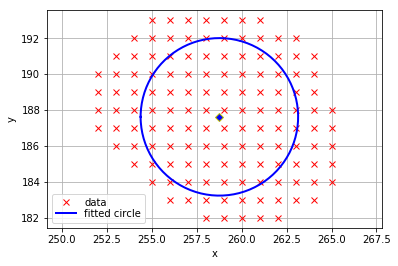

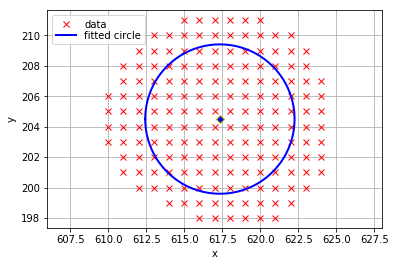

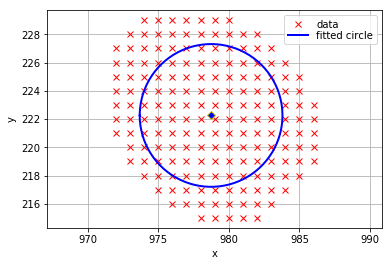

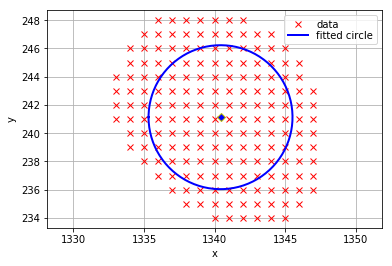

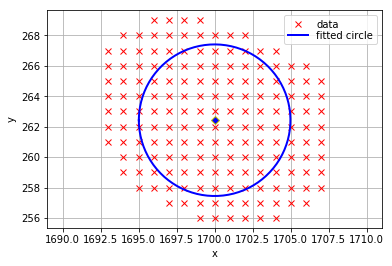

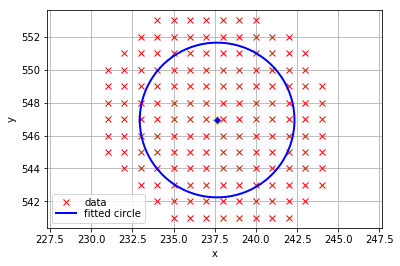

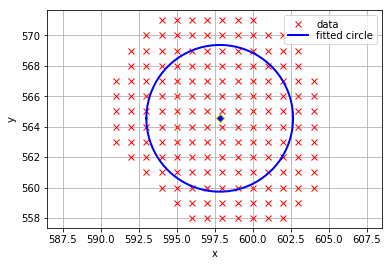

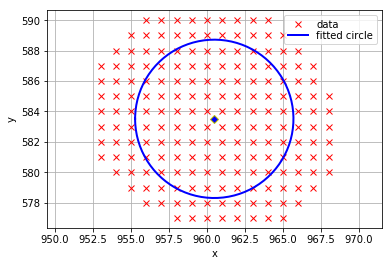

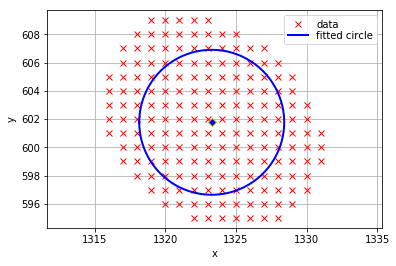

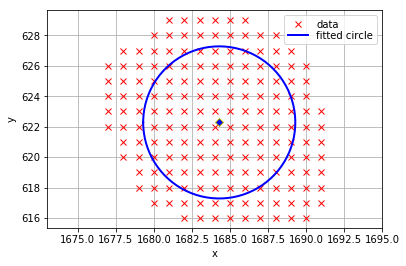

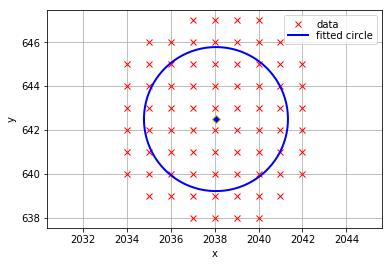

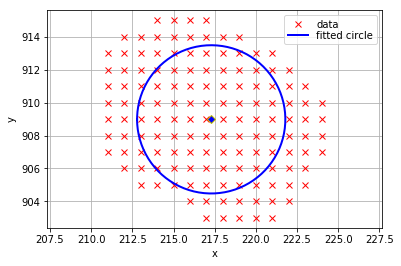

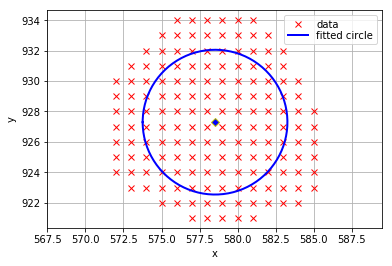

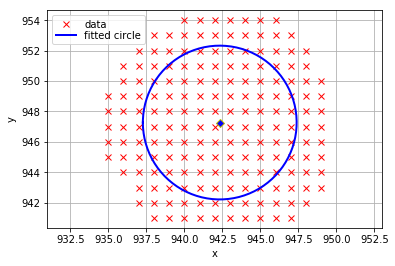

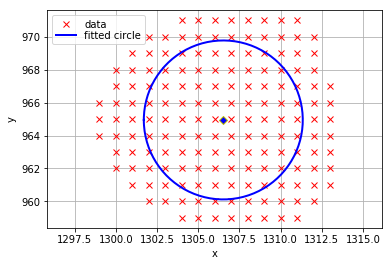

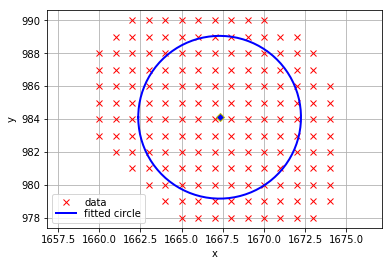

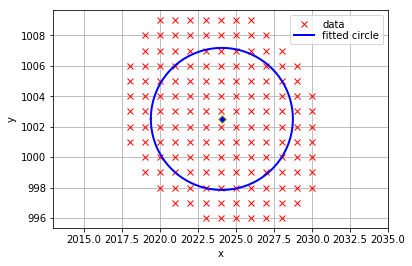

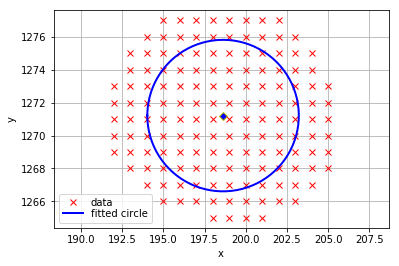

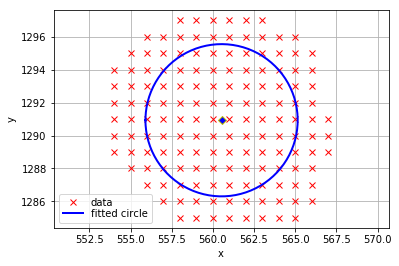

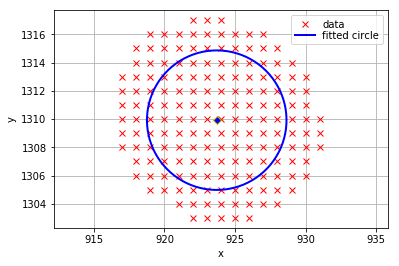

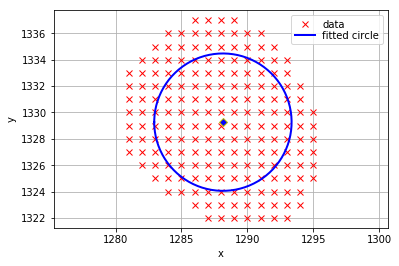

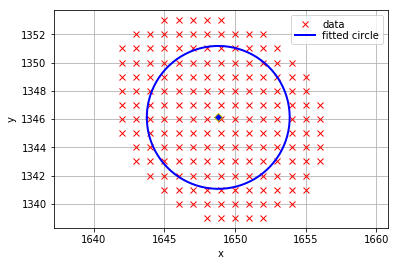

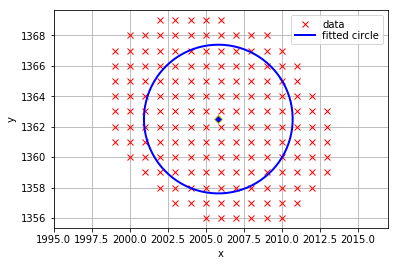

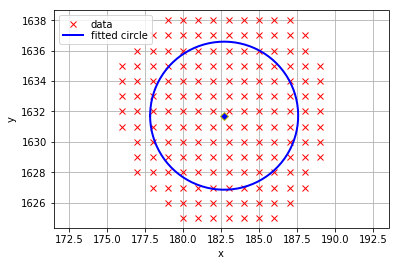

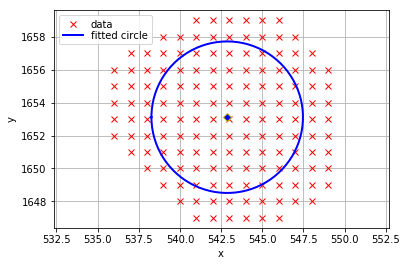

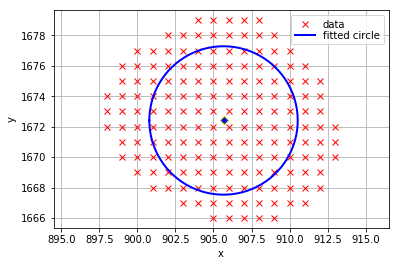

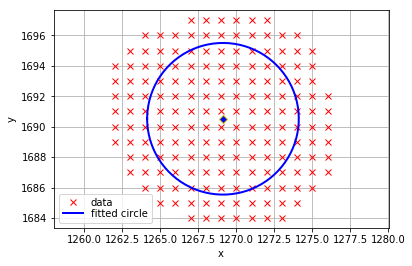

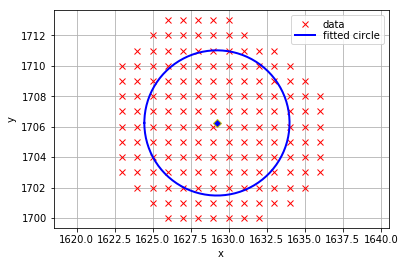

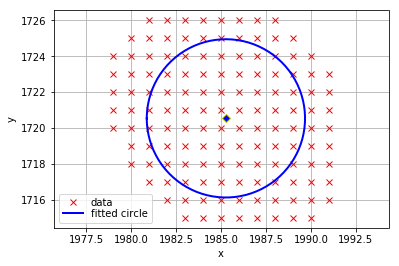

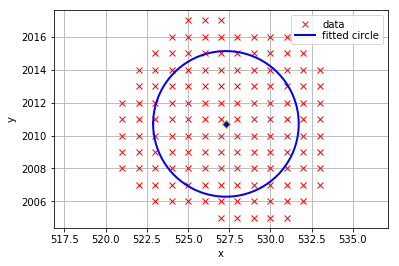

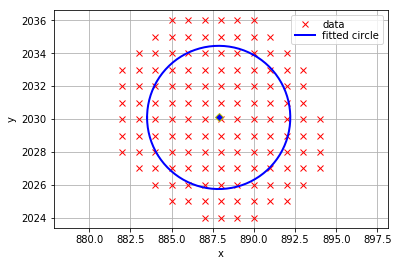

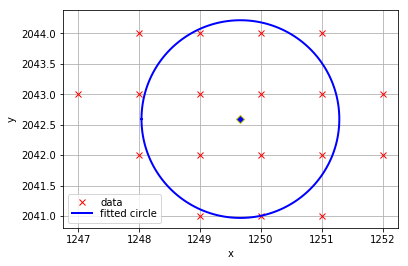

In [71]:
from scipy  import optimize


def calc_R(x,y, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()



def leastsq_circle(x,y):
    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    print x_m,y_m
    center, ier = optimize.leastsq(f, center_estimate, args=(x,y))
    xc, yc = center
    Ri       = calc_R(x, y, *center)
    R        = Ri.mean()
    residu   = np.sum((Ri - R)**2)
    return xc, yc, R, residu


def plot_data_circle(x,y, xc, yc, R):
    f = plt.figure( facecolor='white')  #figsize=(7, 5.4), dpi=72,
    plt.axis('equal')

    theta_fit = np.linspace(-np.pi, np.pi, 180)

    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.xlabel('x')
    plt.ylabel('y')   
    # plot data
    plt.plot(x, y, 'rx', label='data', mew=1)
    plt.plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2)
    plt.plot([xc], [yc], 'bD', mec='y', mew=1)
    plt.legend(loc='best',labelspacing=0.1 )

    plt.grid()
    #plt.title('Least Squares Circle')


## loop on features:
for i in np.arange(numb):
    y, x = props[i].coords[:,0], props[i].coords[:,1]
    xc, yc, R, resid = leastsq_circle(x,y)
    print xc, yc
    plot_data_circle(x,y,xc,yc,R)  

## I will trust the centroids returned by the module measure since they match the centers of fitted circles

# Fitting parabolas
## after retrieving the coordinates of the data points, I will be fitting lines and columns with parabolas of order 2 (the deviation from straight lines)

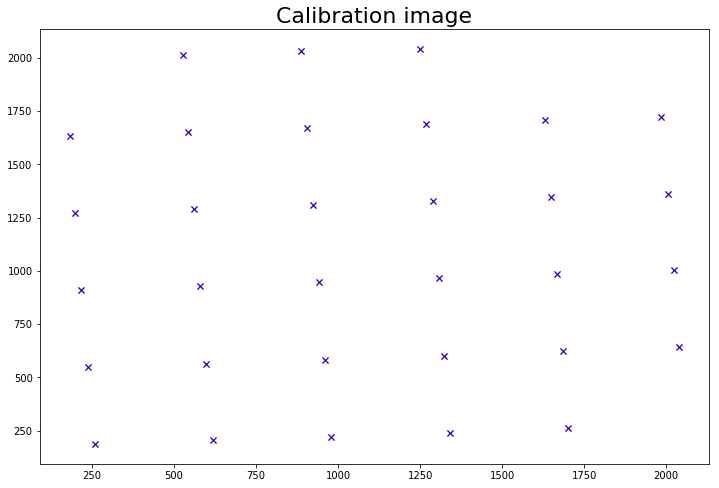

In [4]:
import os
#p=os.getcwd()
p = '/home/fatima/Desktop/solar_orbiter_project/codes/dont_touch/'
fig = plt.figure(figsize=(12,8))
lines = np.loadtxt(p+'centers_python_lines_dots')
columns = np.loadtxt(p+'centers_python_columns_dots')
plt.plot(lines[:,0], lines[:,1],'rx')
plt.plot(columns[:,0], columns[:,1],'bx')

plt.title('Calibration image',fontsize=22)
plt.show()

(2048, 2048, 1023.5, 1023.5)

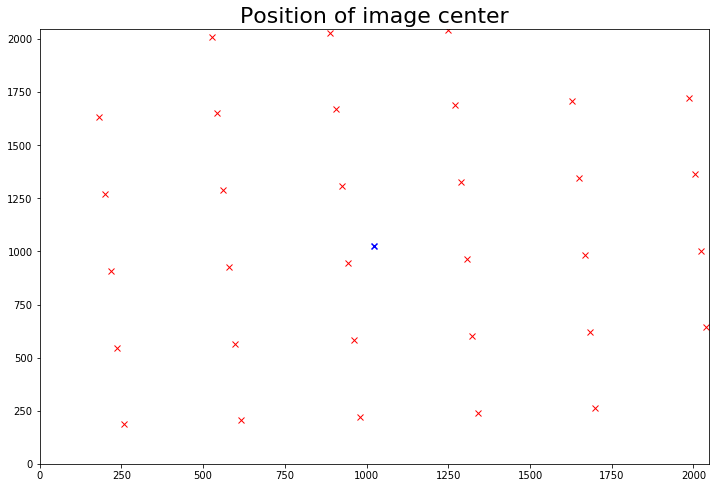

In [5]:
p = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/'
plt.clf()
fig = plt.figure(figsize=(12,8))
image = pyfits.getdata(p+'calibration_points.fits')
Ny, Nx = image.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xc = center[1]
yc = center[0]
plt.scatter(xc,yc,marker='x',color='b')
plt.plot(lines[:,0], lines[:,1],'rx')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.title('Position of image center',fontsize=22)
#plt.plot(columns[:,0], columns[:,1],'bo')
Ny, Nx,xc, yc

In [6]:
LINES=[]
#LINES.append(lines[0:5]);LINES.append(lines[5:10]);LINES.append(lines[10:15]);LINES.append(lines[15:20]);LINES.append(lines[20:25])#;LINES.append(lines[29:32])
LINES.append(lines[0:5]);LINES.append(lines[5:11]);LINES.append(lines[11:17]);LINES.append(lines[17:23]);LINES.append(lines[23:29])#;LINES.append(lines[29:32])

In [7]:
LINES[0]

array([[  258.79699248,   187.66165413],
       [  617.34705882,   204.51176471],
       [  978.7752809 ,   222.2247191 ],
       [ 1340.41666667,   241.15555556],
       [ 1699.98830409,   262.38011696]])

In [8]:
#COLUMNS = []; COLUMNS.append(columns[0:5]); COLUMNS.append(columns[5:11]);COLUMNS.append(columns[11:16]);COLUMNS.append(columns[16:21]);  COLUMNS.append(columns[21:26])#; COLUMNS.append(columns[28:32])
COLUMNS = []; COLUMNS.append(columns[0:5]); COLUMNS.append(columns[5:11]);COLUMNS.append(columns[11:17]);COLUMNS.append(columns[17:23]);  COLUMNS.append(columns[23:28])#; COLUMNS.append(columns[28:32])

In [9]:
COLUMNS

[array([[  258.79699248,   187.66165413],
        [  237.67096774,   546.96129032],
        [  217.24460432,   908.97841727],
        [  198.63758389,  1271.20134228],
        [  182.71856287,  1631.73652695]]),
 array([[  617.34705882,   204.51176471],
        [  597.8404908 ,   564.57668712],
        [  578.50314465,   927.29559748],
        [  560.52666667,  1290.94666667],
        [  542.93918919,  1653.08108108],
        [  527.28467153,  2010.74452555]]),
 array([[  978.7752809 ,   222.2247191 ],
        [  960.47894737,   583.52105263],
        [  942.31111111,   947.27222222],
        [  923.73255814,  1309.93023256],
        [  905.68072289,  1672.42168675],
        [  887.90225564,  2030.06766917]]),
 array([[ 1340.41666667,   241.15555556],
        [ 1323.24725275,   601.77472528],
        [ 1306.52760736,   964.95705521],
        [ 1288.1005291 ,  1329.25396825],
        [ 1269.12      ,  1690.52      ],
        [ 1249.72222222,  2042.61111111]]),
 array([[ 1699.98830409,  

In [10]:
def parabola_lines(x,a,b,c):
    y = a*x**2 + b*x + c
    return y
def parabola_columns(y,m,n,p):
    x = m*y**2 + n*y + p
    return x


0.28946687455 0.144733437275
0.498380898712 0.166126966237
0.88190075069 0.293966916897
0.444566546147 0.148188848716
0.0808967225803 0.0269655741934


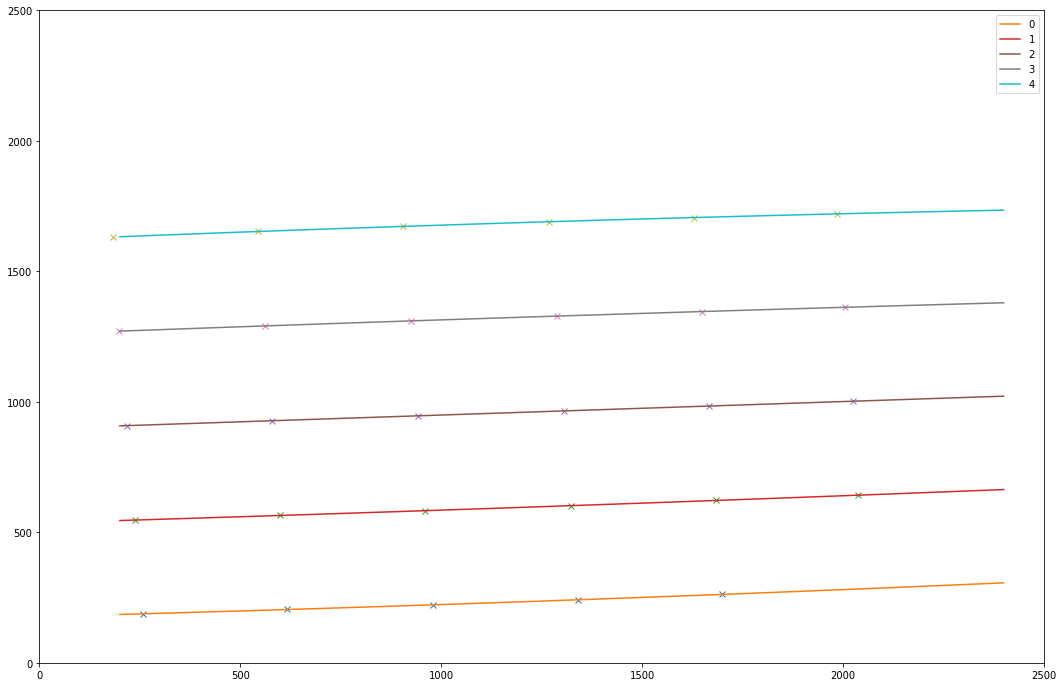

In [11]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0
A = np.zeros(len(LINES))
B = np.zeros(len(LINES))
C = np.zeros(len(LINES))
for line in LINES:
    x = line[:,0]; y = line[:,1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)   ## estimating the guess array for each line
    popt, pcov = curve_fit(parabola_lines, x,y,p0)
     ## GOODNESS OF FIT
    chi_sq_w_lines = np.sum((parabola_lines(x,*popt)-y)**2)
    red_chi_sq_lines = chi_sq_w_lines/(len(x)-len(popt))
    print chi_sq_w_lines, red_chi_sq_lines
    A[n] = popt[0]; B[n] = popt[1]; C[n] = popt[2]
    xnew = np.linspace(200, 2400, 100)
    ynew = parabola_lines(xnew, *popt)
    ax.plot(x,y,'x')
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(0,2500)
    ax.set_ylim(0,2500)
    
    n=n+1

plt.legend()
plt.show()

0.30425748695 0.152128743475
0.173343777531 0.0577812591769
0.0609007398281 0.0203002466094
0.337401079227 0.112467026409
0.00521340475332 0.00260670237666


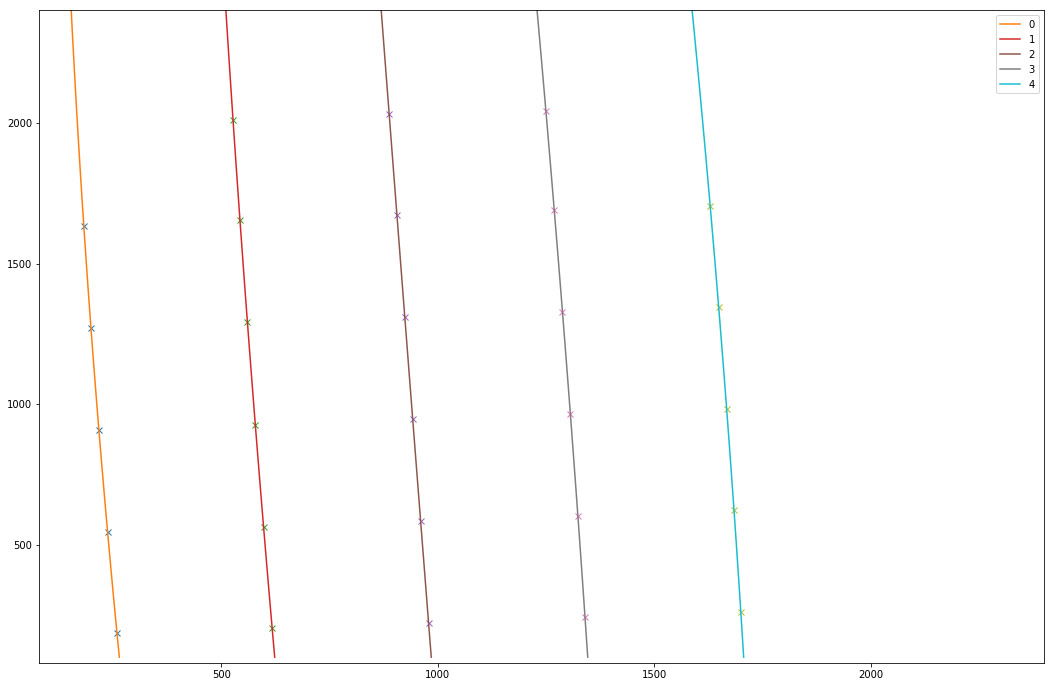

In [12]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0
M = np.zeros(len(COLUMNS))
N =  np.zeros(len(COLUMNS))
P =  np.zeros(len(COLUMNS))
for col in COLUMNS:
    x = col[:,0]; y = col[:,1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)  # estimating the guess array for columns
    
    popt, pcov = curve_fit(parabola_columns, y,x,p0)
    chi_sq_w_cols = np.sum((parabola_columns(y,*popt)-x)**2)
    red_chi_sq_cols = chi_sq_w_cols/(len(x)-len(popt))
    print chi_sq_w_cols ,red_chi_sq_cols
    M[n]=popt[0]; N[n] = popt[1]; P[n] = popt[2]
    ynew = np.linspace(100, 2400, 100)
    xnew = parabola_columns(ynew, *popt)
    ax.plot(x,y,'x')
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(80,2400)
    ax.set_ylim(80,2400)
    n=n+1

plt.legend()
plt.show()

# Determining the center of curvature
## I plot the curvature of each line (column) as a function of the offest from the origin (lower left in the image).

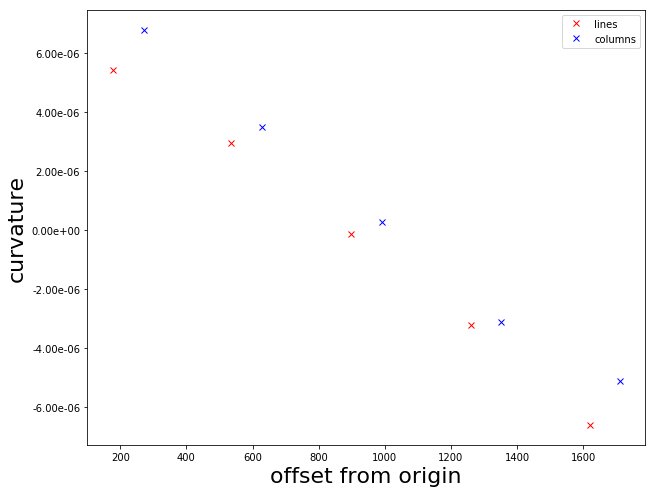

In [13]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(C,A,'rx',label='lines')
ax.plot(P,M,'bx',label='columns')
ax.set_xlabel('offset from origin',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
#ax.set_xlim(P.min(), P.max())
#ax.set_ylim(A.min(), A.max())
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')


## However, it is best to assume first that the origin corresponds to the center of the image

In [14]:
## Shifting to center of image to find the distortion center

C_2 = A*xc**2 + B*xc + C - yc

In [15]:
P_2 = M*yc**2 + N*yc + P - xc

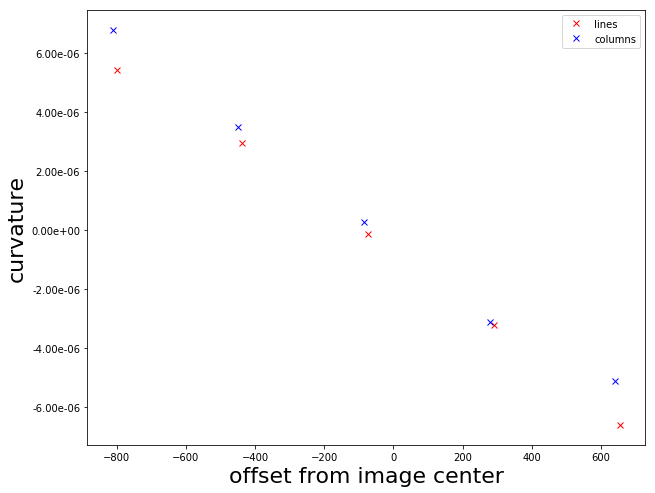

In [16]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(C_2,A,'rx',label='lines')
ax.plot(P_2,M,'bx',label='columns')
ax.set_xlabel('offset from image center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')



## Now I fit this relationship with a polynomial of first degree to find where the curvature is equal to zero (in both horizontal and vertical directions). This point should correspond to the center of distortion. Assuming that distortion is minimum at that point.

9.34294558646e-11 3.11431519549e-11
9.58617083241e-11 3.19539027747e-11


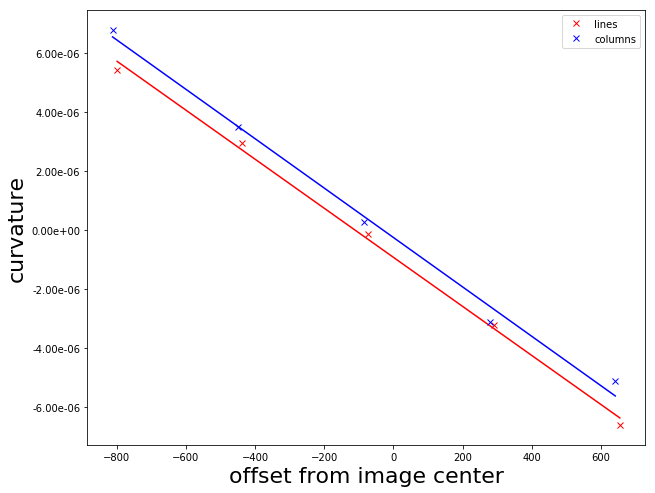

In [17]:
# Lines
t = np.polyfit(C_2, A, 1)
tnew = np.linspace(C_2.min(),C_2.max(),100)
model = np.poly1d(t)
Tnew = model(tnew)
## GOODNESS OF FIT
chi_sq_w_lines = np.sum((model(A)-A)**2)
red_chi_sq_lines = chi_sq_w_lines/(len(A)-len(t))
print chi_sq_w_lines,red_chi_sq_lines

#columns
t2 = np.polyfit(P_2, M, 1)
tnew2 = np.linspace(P_2.min(),P_2.max(),100)
model2 = np.poly1d(t2)
Tnew2 = model2(tnew2)
## goodness of fit
chi_sq_w_cols = np.sum((model2(M)-M)**2)
red_chi_sq_cols = chi_sq_w_cols/(len(M)-len(t2))
print chi_sq_w_cols ,red_chi_sq_cols

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(C_2,A,'rx',label='lines')
ax.plot(tnew,Tnew,'r')
ax.plot(P_2,M,'bx',label='columns')
ax.plot(tnew2, Tnew2, 'b')
ax.set_xlabel('offset from image center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
## the last point in the lines data is ignored

In [18]:
'''
def equations(p):
    p = xc,yc
    eq1 = A[0]*xc**2 + B[0]*xc - yc + C[0] + (t[1]/t[0])
    eq2 = M[0]*xc**2 + N[0]*xc - yc + P[0] + (t2[1]/t2[0]) 
    return(eq1,eq2)
    from scipy.optimize import fsolve
xc,yc = fsolve(equations,(1000,1000))
print equations((xc, yc))


'''

'\ndef equations(p):\n    p = xc,yc\n    eq1 = A[0]*xc**2 + B[0]*xc - yc + C[0] + (t[1]/t[0])\n    eq2 = M[0]*xc**2 + N[0]*xc - yc + P[0] + (t2[1]/t2[0]) \n    return(eq1,eq2)\n    from scipy.optimize import fsolve\nxc,yc = fsolve(equations,(1000,1000))\nprint equations((xc, yc))\n\n\n'

In [19]:
## Finding distortion center:

del_lines = -t[1]/t[0]
del_columns = -t2[1]/t2[0]
y_d = del_lines+yc
x_d = del_columns + xc
print 'the distortion center is:', (x_d,y_d)
del_lines, del_columns

the distortion center is: (993.30000868228387, 912.22067570342199)


(-111.27932429657797, -30.199991317716098)

# Refining the distortion center coordinates


In [20]:

Ny, Nx = image.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xd = center[1]
yd = center[0]
C_2 = A*xc**2 + B*xc + C - yd #lines
P_2 = M*yc**2 + N*yc + P - xd #columns
trials = 10
i=0
temp_x = temp_y = np.zeros((10))
yd_error = xd_error=0

In [21]:
for n in range(trials):
    
    t,V = np.polyfit(C_2, A, 1,cov=True)
    t2,V2 = np.polyfit(P_2, M, 1,cov=True)
    t_1_error = np.sqrt(V[0][0]); t_2_error = np.sqrt(V[1][1])
    t2_1_error = np.sqrt(V2[0][0]); t2_2_error = np.sqrt(V2[1][1])
                                                 
                                                      
    del_lines = -t[1]/t[0]
    del_columns = -t2[1]/t2[0]
    del_lines_error = del_lines*(np.sqrt((t_2_error/t[1])**2+( t_1_error/t[0])**2))
    del_columns_error = del_columns*(np.sqrt((t2_2_error/t2[1])**2+( t2_1_error/t2[0])**2))
    
    yd = del_lines+yd
    xd = del_columns + xd
    yd_error = np.sqrt(del_lines_error**2 + yd_error**2)
    xd_error = np.sqrt(del_columns_error**2 + xd_error**2)
    
    print 'the distortion center is:', (xd,yd), 'plus minus', (xd_error,yd_error)
    print del_lines, del_columns
    
   
    C_2 = A*x_d**2 + B*x_d + C - yd#lines
    P_2 = M*y_d**2 + N*y_d + P - xd #columns
    temp_x[i] = xd
    temp_y[i] = yd
    i=i+1


the distortion center is: (993.30000868228387, 912.22067570342199) plus minus (43.510015543119046, 27.275748057208649)
-111.279324297 -30.1999913177
the distortion center is: (998.88199804439159, 910.66450263868876) plus minus (61.217501441914401, 38.0085816655589)
-1.55617306473 5.58198936211
the distortion center is: (998.88199804439171, 910.66450263868887) plus minus (74.872334017290555, 46.321098920099885)
1.38487040399e-13 5.79427653645e-14
the distortion center is: (998.88199804439159, 910.66450263868876) plus minus (86.395314222489276, 53.353876429964309)
-9.00738056441e-14 -1.34733349138e-13
the distortion center is: (998.88199804439171, 910.66450263868887) plus minus (96.552753653164089, 59.56196819315258)
1.38487040399e-13 5.79427653645e-14
the distortion center is: (998.88199804439159, 910.66450263868876) plus minus (105.73891505219129, 65.181438922290923)
-9.00738056441e-14 -1.34733349138e-13
the distortion center is: (998.88199804439171, 910.66450263868887) plus minus (114

In [22]:
## The final center of distortion:
x_d = xd
y_d = yd

In [23]:
print x_d, y_d

998.881998044 910.664502639


## Now I should recalculate the coefficients of parabolas in the reference frame of the new distortion center

In [24]:
## parabola coefficient in the new reference of distortion center
C_3 = A*x_d**2 + B*x_d + C - y_d
P_3 = M*y_d**2 + N*y_d + P - x_d
B_3 = 2*A*x_d + B
N_3 = 2*M*y_d + N

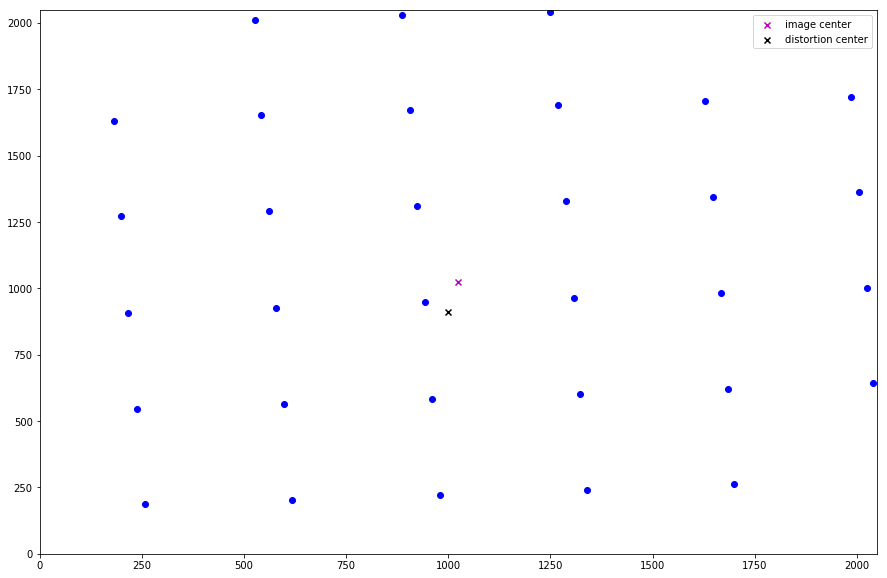

In [25]:
plt.clf()
fig = plt.figure(figsize=(15,10))
plt.scatter(xc,yc,marker='x', color='m',label='image center')
plt.scatter(x_d,y_d,marker='x',color='k',label='distortion center')
#plt.plot(lines[:,0], lines[:,1],'rx')
plt.plot(columns[:,0], columns[:,1],'bo')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.legend(loc='best')


# correcting for aspect ratio

In [26]:
## slope of curvature versus offset in the lines
s_x = t[0]

## slope of curvature versus offset in columns
s_y = t2[0]

## aspect ratio
AR = np.sqrt(np.abs(s_x/s_y))
print AR



0.996409619285


In [27]:
## correcting the coefficients:
M_4 = M/AR
N_4 = N_3/AR
P_4 = P_3/AR

A_4 = A*AR**2
B_4 = B_3*AR
C_4 = C_3

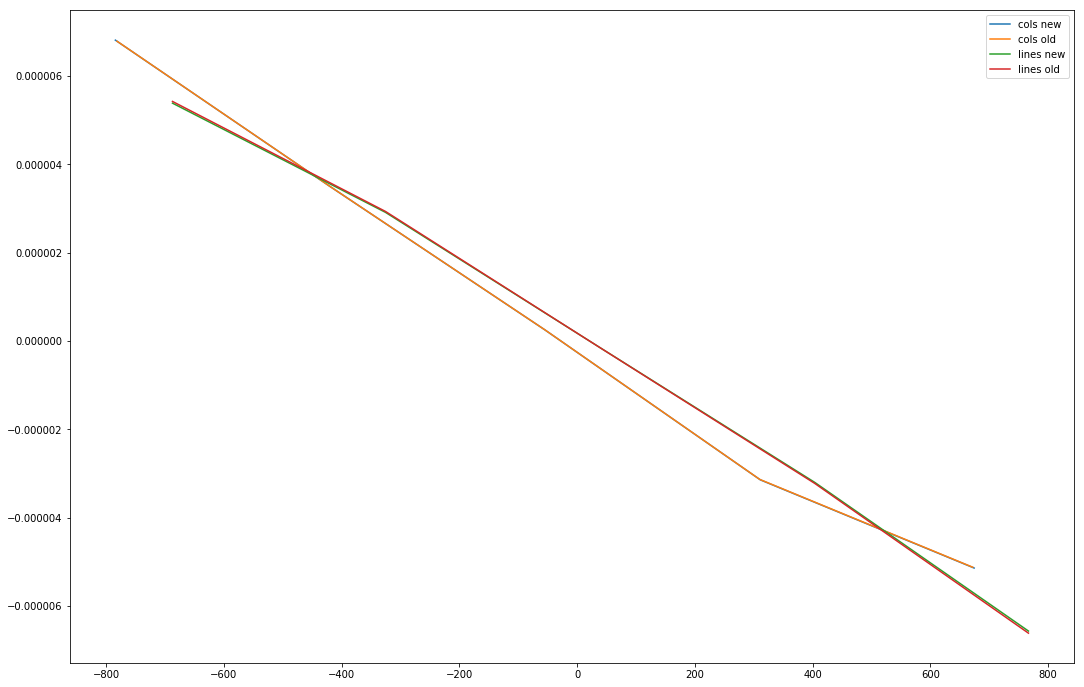

In [28]:
plt.figure(figsize=(18,12))
plt.plot(P_4,M_4,label='cols new')
plt.plot(P_3,M,label='cols old')
plt.plot(C_4,A_4,label='lines new')
plt.plot(C_3,A,label='lines old')
plt.legend()

plt.show()


# determining the distortion coefficient:

[  7.91769655e-09   8.96879302e-09   3.78592716e-09   7.94727571e-09
   8.68849315e-09]
7.46163711694e-09
8.27080918262e-09


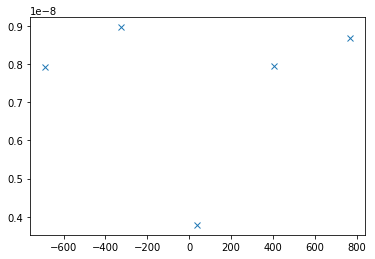

In [29]:
## without correcting for aspect ratio
k_lines = (-A)/(C_3*(3*A*C_3 + 3*B_3**2 + 1))
plt.plot(C_3, k_lines,'x')
print k_lines
print k_lines.mean()
print np.average(k_lines,weights=np.abs(C_3))

[  7.86076640e-09   8.90484239e-09   3.75900497e-09   7.89053583e-09
   8.62574143e-09]
7.40817820287e-09
8.2114008117e-09


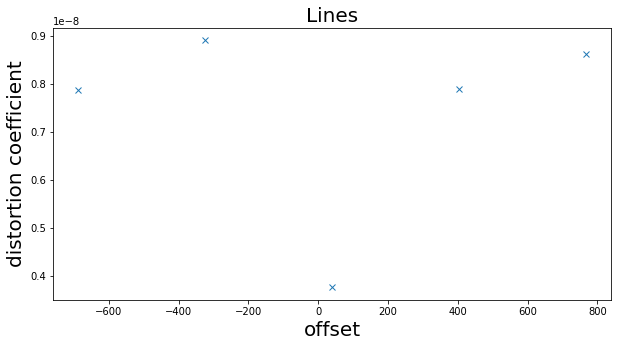

In [30]:
# correcting for aspect ratio
k_lines_4 = (-A_4)/(C_4*(3*A_4*C_4 + 3*B_4**2 + 1))
plt.figure(figsize=(10,5))
plt.plot(C_4, k_lines_4,'x')
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Lines',fontsize=20)
print k_lines_4
print k_lines_4.mean()
print np.average(k_lines_4,weights=np.abs(C_4))

[  8.75103250e-09   8.31084770e-09   4.63698760e-09   1.00493253e-08
   7.64154367e-09]
7.87794735883e-09
8.41438121255e-09


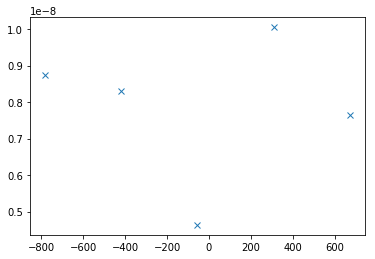

In [31]:
k_cols = (-M)/(P_3*(3*M*P_3+ 3*N_3**2 + 1))
plt.plot(P_3,k_cols,'x')
print k_cols
print k_cols.mean()
print np.average(k_cols,weights=np.abs(P_3))

[  8.75100370e-09   8.31050557e-09   4.63673493e-09   1.00489155e-08
   7.64144194e-09]
7.87772033636e-09
8.41421351639e-09


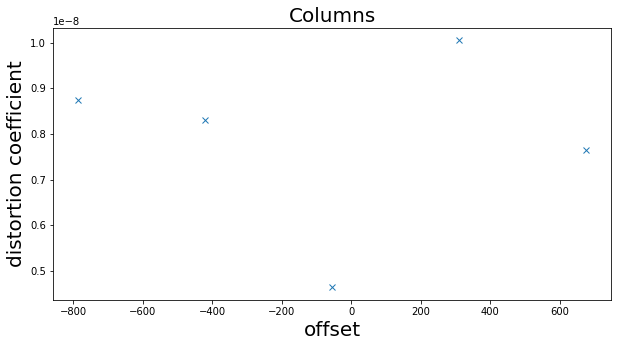

In [32]:
plt.figure(figsize=(10,5))
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Columns',fontsize=20)
k_cols_4 = (-M_4)/(P_4*(3*M*P_4+ 3*N_4**2 + 1))
plt.plot(P_4,k_cols_4,'x')
print k_cols_4
print k_cols_4.mean()
print np.average(k_cols_4,weights=np.abs(P_4))

In [33]:
K = np.array([k_lines.mean() ,k_cols.mean()])
print K.mean()
K = np.array([np.average(k_lines, weights=np.abs(C_3)), np.average(k_cols, weights=np.abs(P_3))])
print K.mean()
K = np.array([np.average(k_lines_4, weights=np.abs(C_4)), np.average(k_cols_4, weights=np.abs(P_4))])
print K.mean()


7.66979223789e-09
8.34259519758e-09
8.31280716404e-09


In [34]:
K = np.array([np.average(k_lines, weights=np.abs(C_4)), np.average(k_cols, weights=np.abs(P_4))])

print "the distortion coefficient is k =", K.mean()

the distortion coefficient is k = 8.34259519758e-09


In [35]:
k = 8.34259519758e-09#K.mean()
# correcting for distortion
## loading all data points
f = np.loadtxt('/home/fatima/Desktop/solar_orbiter_project/codes/dont_touch/centers_python_lines_dots_outliers')
X_d = f[:,0] 
Y_d = f[:,1] 

In [36]:
# computing the undistorted coordinates
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2)) 
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))


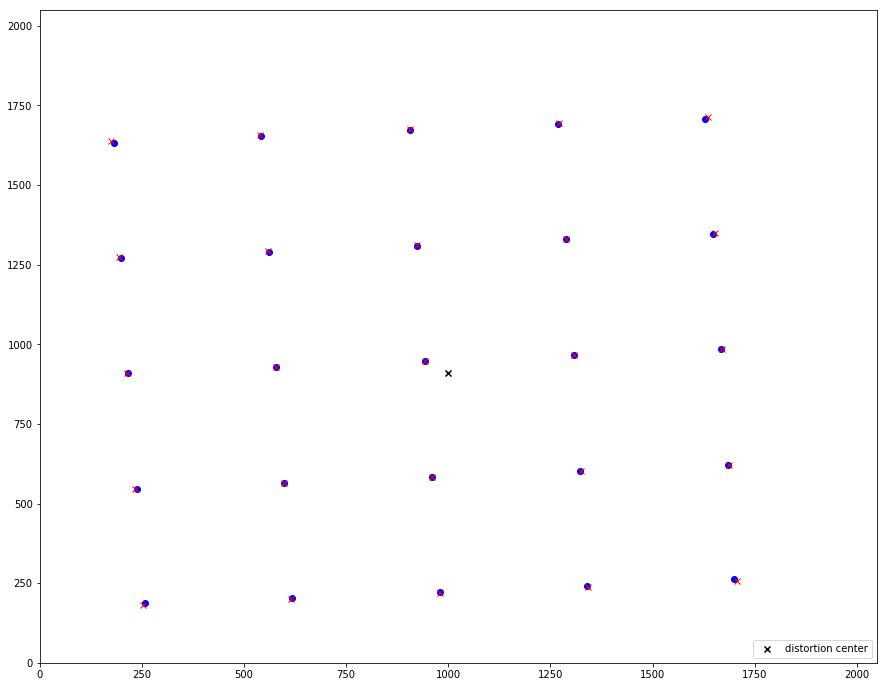

In [37]:
plt.clf()
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
#plt.scatter(xc,yc,marker='x',color='m',label='image center')
plt.scatter(x_d,y_d,marker='x',color='k',label='distortion center')
#plt.plot(lines[:,0], lines[:,1],'rx')
ax.plot(X_d, Y_d,'bo')
ax.plot(X_u,Y_u, 'rx')
plt.xlim(0,2048)
plt.ylim(0,2048)
#rec = plt.Rectangle((0,0), width=Nx,height=Ny, fill='False')
#ax.add_patch(rec)
plt.legend(loc='lower right')


In [38]:
plate_scale = 0.5
d_m_pixels = np.sqrt((1./len(X_u))*np.sum((X_u-X_d)**2+(Y_u-Y_d)**2))
d_m_arc = d_m_pixels*plate_scale
d_m_km = d_m_arc*725
print "the distortion is around:",'\n', d_m_pixels, 'pixels', '\n', d_m_arc, 'arcseconds', '\n',d_m_km, 'km'

the distortion is around: 
4.68764819563 pixels 
2.34382409781 arcseconds 
1699.27247091 km


In [39]:
# disortionpercent:
D=((np.sqrt((X_d-x_d)**2+(Y_d-y_d)**2) - np.sqrt((X_u-x_d)**2+(Y_u-y_d)**2))/np.sqrt((X_u-x_d)**2+(Y_u-y_d)**2))*100
print D.mean()
print np.abs(D).max()
print D

-0.439554917509
0.979793261969
[-0.88513593 -0.53457411 -0.39417414 -0.46905285 -0.75495386 -0.59025636
 -0.23355569 -0.09043333 -0.16709424 -0.4591528  -0.50711432 -0.14744203
 -0.00378772 -0.08135207 -0.37580559 -0.63859093 -0.28016638 -0.13751398
 -0.21549479 -0.50802382 -0.97979326 -0.6292733  -0.48894349 -0.56508883
 -0.85209912]


In [40]:
np.sqrt((X_u-X_d)**2+(Y_u-Y_d)**2)

array([  9.23966420e+00,   4.31373123e+00,   2.72555214e+00,
         3.54197001e+00,   7.26384835e+00,   5.00918411e+00,
         1.24010473e+00,   2.98147763e-01,   7.49688866e-01,
         3.42991435e+00,   3.98400786e+00,   6.21215912e-01,
         2.55235432e-03,   2.54350459e-01,   2.53657102e+00,
         5.64101071e+00,   1.63042608e+00,   5.59456273e-01,
         1.09877790e+00,   3.99478524e+00,   1.07761926e+01,
         5.51722467e+00,   3.77077317e+00,   4.69046787e+00,
         8.72286807e+00])

In [41]:
#another formula (works because the distortion is radial)
r_d = np.sqrt((X_d-x_d)**2 + (Y_d-y_d)**2)
rms =  np.sqrt((1./len(X_u))*np.sum((k*r_d**3)**2))
print rms

4.68764819563


In [42]:
np.sqrt(((X_u-X_d)**2+(Y_u-Y_d)**2)).max()


10.776192581972733

In [43]:
print k*r_d**2

[  8.93040557e-03   5.37447168e-03   3.95734020e-03   4.71263325e-03
   7.60696765e-03   5.93761070e-03   2.34102454e-03   9.05151817e-04
   1.67373911e-03   4.61270741e-03   5.09699078e-03   1.47659742e-03
   3.78786390e-05   8.14183083e-04   3.77223211e-03   6.42695126e-03
   2.80953512e-03   1.37703345e-03   2.15960173e-03   5.10617876e-03
   9.89488201e-03   6.33258221e-03   4.91345892e-03   5.68300233e-03
   8.59422250e-03]


## After retrieveing the distortion coefficient, the undistorted points should lie on straight lines of the form: 
\begin{equation}
y = b(3kc^2 + 1) x + c(kc^2+1)
\end{equation}


[  5.23766816e-02  -6.92035970e+02]
[  5.21734013e-02  -6.92099397e+02]
[  5.22857296e-02  -3.27750240e+02]
[  5.23081265e-02  -3.27669528e+02]
[  0.05182098  36.98967721]
[  0.05186108  37.04802103]
[  5.15411626e-02   4.02209992e+02]
[  5.14871149e-02   4.02247944e+02]
[  5.11366378e-02   7.68495650e+02]
[  5.08095340e-02   7.68361708e+02]


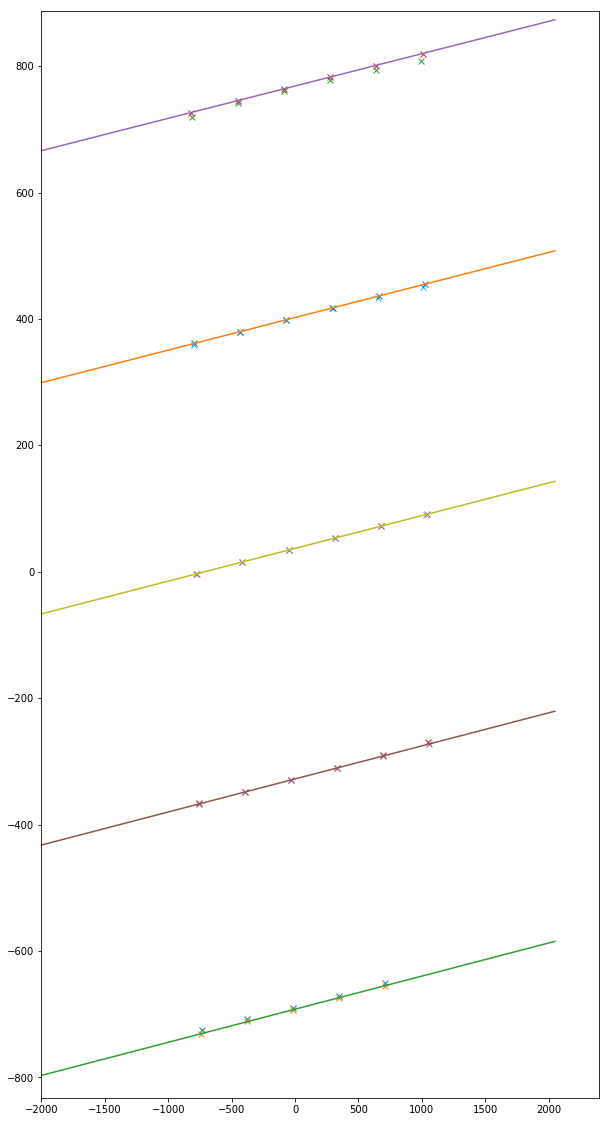

In [78]:
plt.clf()
fig=plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
n=0
y_new_array = np.zeros((5,100))
for line in LINES:
    X_d = line[:,0] -x_d  
    Y_d = line[:,1] -y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2))
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2))
    params = np.array([B_3[n]*(3*k*C_3[n]**2 +1), C_3[n]*(k*C_3[n]**2+1)])
    
    xnew = np.linspace(-2048, 2048, 100)    

    ynew = params[0]*xnew + params[1]
    t_fit = t = np.polyfit(X_u,Y_u, 1)
    ax.plot(X_d,Y_d,'x',label='distorted')
    ax.plot(X_u,Y_u,'x',label='undistorted')
    ax.plot(xnew, ynew,label='straight')
   # xnew_array[i] = xnew
    y_new_array[n] = ynew
    ax.set_xlim(-2000,2400)
    ax.set_ylim(80-y_d,1800-y_d)
    n=n+1
    print params
    print t_fit
    

#plt.legend()
plt.show()

In [47]:
type(LINES)
type(LINES[0])

numpy.ndarray

[ -5.36869351e-02  -7.80106359e+02]
[ -5.34139723e-02  -7.79992732e+02]
[ -5.15879972e-02  -4.14536397e+02]
[ -5.14727506e-02  -4.14509789e+02]
[ -0.05042182 -49.40633882]
[ -0.0504856 -49.458249 ]
[ -4.88645424e-02   3.15859073e+02]
[ -4.90704492e-02   3.15689332e+02]
[ -4.88286955e-02   6.80043926e+02]
[ -4.85760284e-02   6.80161354e+02]


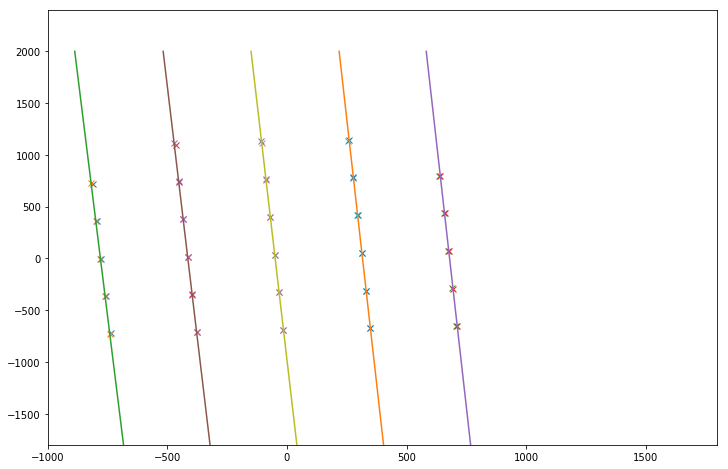

In [87]:
plt.clf()
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
n=0
x_new_array = np.zeros((5,100))

for col in COLUMNS:
    X_d = col[:,0] - x_d
    Y_d = col[:,1] - y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2)) 
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2)) 
    params = np.array([N_3[n]*(3*k*P_3[n]**2 +1), P_3[n]*(k*P_3[n]**2+1)])
    
    ynew = np.linspace(-2000,2000, 100) 
    t_fit = np.polyfit(Y_u,X_u, 1)

    xnew = params[0]*ynew + params[1] 
    x_new_array[n]= xnew
    ax.plot(X_d,Y_d,'x',label='distorted')
    ax.plot(X_u,Y_u,'x',label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    ax.set_xlim(-1000,1800)
    ax.set_ylim(-1800,2400)
    print params
    print t_fit
    n=n+1

#plt.legend()
plt.show()


# plotting everything together

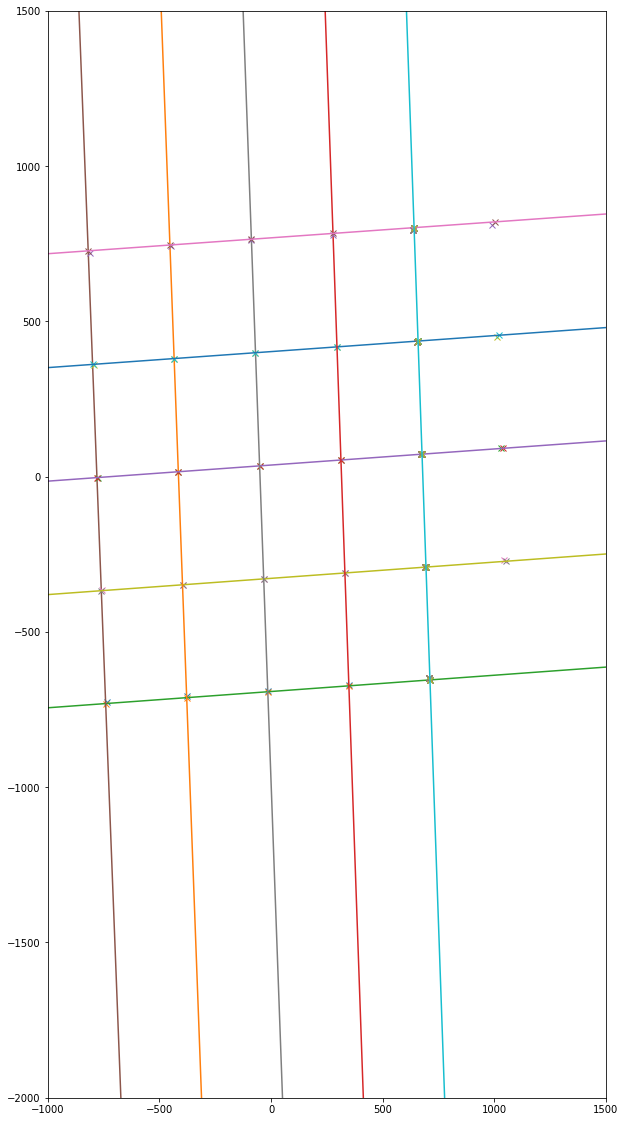

In [97]:
plt.clf()
fig=plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
n=0
for line in LINES or col in COLUMNS:
    X_d = line[:,0] -x_d  
    Y_d = line[:,1] -y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2))
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2))
    params = np.array([B_3[n]*(3*k*C_3[n]**2 +1), C_3[n]*(k*C_3[n]**2+1)])
    
    xnew = np.linspace(-2048, 2048, 100)    

    ynew = params[0]*xnew + params[1]
    t_fit = t = np.polyfit(X_u,Y_u, 1)
    ax.plot(X_d,Y_d,'x',label='distorted')
    ax.plot(X_u,Y_u,'x',label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    
    
    X_d = col[:,0] - x_d
    Y_d = col[:,1] - y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2)) 
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2)) 
    params = np.array([N_3[n]*(3*k*P_3[n]**2 +1), P_3[n]*(k*P_3[n]**2+1)])
    
    ynew = np.linspace(-2000,2000, 100) 
    t_fit = np.polyfit(Y_u,X_u, 1)

    xnew = params[0]*ynew + params[1] 
    ax.plot(X_d,Y_d,'x',label='distorted')
    ax.plot(X_u,Y_u,'x',label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    ax.set_xlim(-1000,1500)
    ax.set_ylim(-2000,1500)
   
    
    n=n+1
    
    

#plt.legend()
plt.show()

In [98]:
k = 8.32643494259e-09

-8.3171259720409381e-06

In [101]:
print x_c 
print y_c

998.881998044
910.664502639


In [102]:
print -k*x_c
print -k*y_c

-8.31712597204e-06
-7.58258873575e-06


In [119]:
k = K.mean()
# correcting for distortion
## loading all data points
f = np.loadtxt(p+'/dont_touch/centers_python_lines_dots_outliers')
X_d = f[:,0] 
Y_d = f[:,1] 

In [120]:
k1 = 8.32643494259e-09
x_d_1 = x_d
y_d_1 = y_d
X_u_1 = X_d + (X_d - x_d_1 )*(k1*((X_d-x_d_1)**2 + (Y_d-y_d_1)**2))
Y_u_1 = Y_d + (Y_d - y_d_1)*(k1*((X_d-x_d_1)**2 + (Y_d-y_d_1)**2))


In [121]:
k2 = 7.99361716474e-09
x_d_2 = 1017.3838085518468 
y_d_2 = 906.04624252300118
X_u_2 = X_d + (X_d - x_d_2 )*(k2*((X_d-x_d_2)**2 + (Y_d-y_d_2)**2))
Y_u_2 = Y_d + (Y_d - y_d_2)*(k2*((X_d-x_d_2)**2 + (Y_d-y_d_2)**2))


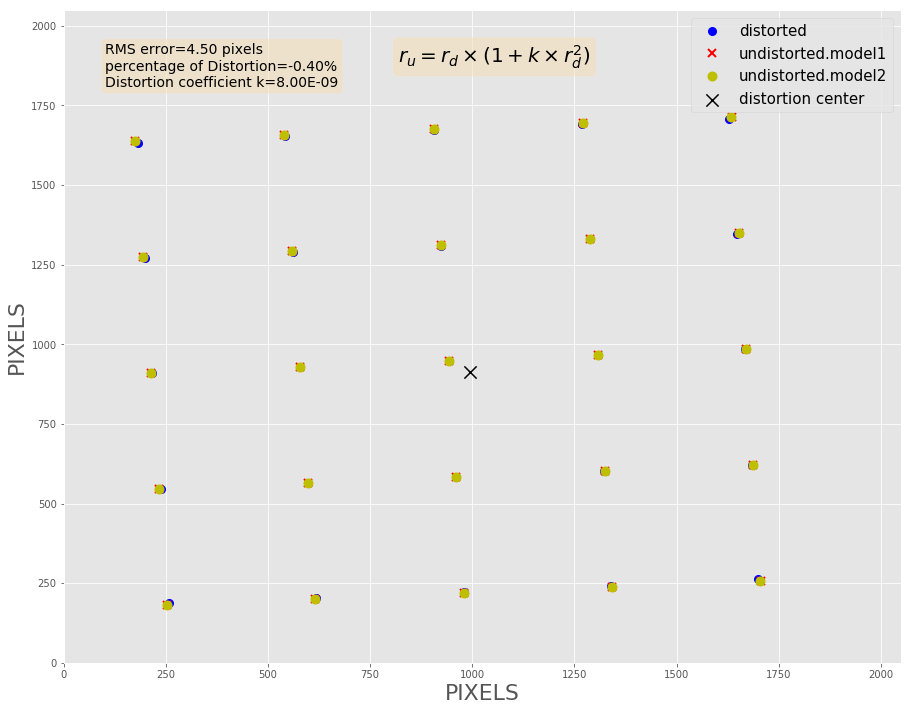

In [122]:
fig = plt.figure(figsize=(15,12))
plt.style.use('ggplot')
ax = fig.add_subplot(111)

#plt.scatter(xc,yc,marker='x',color='m',label='image center')
plt.scatter(x_d,y_d,marker='x',color='k',s=150,alpha=1,label='distortion center')
#plt.plot(lines[:,0], lines[:,1],'rx')
ax.plot(X_d, Y_d,'bo', markersize=8 ,label='distorted')
ax.plot(X_u_1,Y_u_1, 'rx', markersize=8,mew=2, label='undistorted.model1')
ax.plot(X_u_2,Y_u_2, 'yo', markersize=8,mew=2, label='undistorted.model2')

plt.xlim(0,2048)
plt.ylim(0,2048)
plt.xlabel('PIXELS',fontsize=22)
plt.ylabel('PIXELS',fontsize=22)
#rec = plt.Rectangle((0,0), width=Nx,height=Ny, fill='False')
#ax.add_patch(rec)
rms = 4.5 
percent = -0.4
k=8e-09
textstr = '\n'.join((
    r'RMS error=%.2f' % (rms, ) +' pixels',
    r'percentage of Distortion=%.2f' % (percent, )+'%',
    r'Distortion coefficient k=%.2E' % (k, )))
text = r'$r_u = r_d \times (1+k\times r_d^2)$'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.text(0.4, 0.95, text, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.legend(loc='upper right',prop={'size': 15} )


In [123]:
np.sqrt((1./len(X_u_2))*np.sum((X_u_1-X_u_2)**2+(Y_u_1-Y_u_2)**2))

0.28805572535347923